# STA Density Comparison Analysis

이 노트북에서는 다양한 STA 밀도 조건에서 훈련된 DRL 모델들을 비교 분석합니다.

## Step 1: 필요한 라이브러리 Import

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import re
import seaborn as sns

# 프로젝트 모듈들 import
import sys
sys.path.append('.')
from drl_framework.network import DQN
from drl_framework.configs import PPDU_DURATION_VARIANTS

# 스타일 설정
plt.style.use('default')
sns.set_palette("husl")

print("라이브러리 import 완료!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

라이브러리 import 완료!
PyTorch version: 2.6.0
CUDA available: False


## Step 2: Density Comparison 모델들 자동 검색

In [12]:
# density_comparison_results 폴더에서 모델들 찾기
model_dir = Path('./density_comparison_results')
model_files = list(model_dir.glob('*/model.pth'))

# ch0_xx_ch1_yy 패턴으로 필터링
density_models = []
pattern = re.compile(r'ch0_(\d+)_ch1_(\d+)')

for model_file in model_files:
    folder_name = model_file.parent.name
    match = pattern.match(folder_name)
    if match:
        ch0_stas = int(match.group(1))
        ch1_stas = int(match.group(2))
        density_models.append({
            'path': model_file,
            'name': folder_name,
            'ch0_stas': ch0_stas,
            'ch1_stas': ch1_stas,
            'total_stas': ch0_stas + ch1_stas
        })

# 총 STA 수로 정렬
density_models.sort(key=lambda x: (x['total_stas'], x['ch1_stas']))

print("🔍 발견된 STA Density 모델들:")
print(f"{'Index':<3} {'Name':<20} {'CH0 STAs':<8} {'CH1 STAs':<8} {'Total':<6} {'Path':<10}")
print("-" * 70)

for i, model in enumerate(density_models):
    print(f"{i+1:<3} {model['name']:<20} {model['ch0_stas']:<8} {model['ch1_stas']:<8} {model['total_stas']:<6} {str(model['path'])[:40]:<10}")
    
print(f"\n총 {len(density_models)}개 모델 발견")

🔍 발견된 STA Density 모델들:
Index Name                 CH0 STAs CH1 STAs Total  Path      
----------------------------------------------------------------------
1   ch0_2_ch1_2          2        2        4      density_comparison_results/ch0_2_ch1_2/m
2   ch0_10_ch1_2         10       2        12     density_comparison_results/ch0_10_ch1_2/
3   ch0_2_ch1_10         2        10       12     density_comparison_results/ch0_2_ch1_10/
4   ch0_10_ch1_10        10       10       20     density_comparison_results/ch0_10_ch1_10
5   ch0_20_ch1_2         20       2        22     density_comparison_results/ch0_20_ch1_2/
6   ch0_2_ch1_20         2        20       22     density_comparison_results/ch0_2_ch1_20/
7   ch0_20_ch1_10        20       10       30     density_comparison_results/ch0_20_ch1_10
8   ch0_10_ch1_20        10       20       30     density_comparison_results/ch0_10_ch1_20
9   ch0_20_ch1_20        20       20       40     density_comparison_results/ch0_20_ch1_20

총 9개 모델 발견


## Step 3: 모델 로드 및 예측 함수

In [13]:
device = torch.device('cpu')  # CPU 사용

def load_model(model_path):
    """모델 로드 함수"""
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # DQN 모델 초기화 및 가중치 로드
    model = DQN(n_observations=4, n_actions=2).to(device)
    model.load_state_dict(checkpoint['policy_net_state_dict'])
    model.eval()
    
    return model, checkpoint

def predict_q_values(model, input_vector):
    """
    Q-values 예측
    
    Args:
        model: 로드된 DQN 모델
        input_vector: [obss_remain, radio_time, ppdu_duration, cw_index]
    
    Returns:
        dict: 예측 결과
    """
    input_tensor = torch.tensor(input_vector, dtype=torch.float32, device=device).unsqueeze(0)
    
    with torch.no_grad():
        q_values = model(input_tensor)
        predicted_action = q_values.argmax(dim=1).item()
        confidence = torch.softmax(q_values, dim=1).squeeze().tolist()
        
    return {
        'q_values': q_values.squeeze().tolist(),
        'predicted_action': predicted_action,
        'action_name': 'Stay Primary' if predicted_action == 0 else 'Switch to NPCA',
        'confidence': confidence
    }

print("✅ 모델 로드 및 예측 함수 준비 완료!")

✅ 모델 로드 및 예측 함수 준비 완료!


## Step 4: 테스트 시나리오 정의

In [14]:
# 다양한 네트워크 상황을 대표하는 테스트 케이스들
test_scenarios = [
    {
        'name': 'Light Traffic, Low Contention',
        'input': [20, 1, 33, 0],
        'description': 'OBSS가 짧고 충돌이 거의 없는 상황'
    },
    {
        'name': 'Light Traffic, High Contention', 
        'input': [15, 1, 33, 5],
        'description': 'OBSS는 짧지만 충돌이 많은 상황'
    },
    {
        'name': 'Medium Traffic, Low Contention',
        'input': [60, 1, 33, 1],
        'description': 'OBSS가 중간이고 충돌이 적은 상황'
    },
    {
        'name': 'Medium Traffic, High Contention',
        'input': [50, 1, 33, 4],
        'description': 'OBSS가 중간이고 충돌이 많은 상황'
    },
    {
        'name': 'Heavy Traffic, Low Contention',
        'input': [120, 1, 33, 0],
        'description': 'OBSS가 길고 충돌이 적은 상황'
    },
    {
        'name': 'Heavy Traffic, High Contention',
        'input': [150, 1, 33, 6],
        'description': 'OBSS가 길고 충돌이 매우 많은 상황'
    },
    {
        'name': 'Critical Situation',
        'input': [5, 1, 33, 7],
        'description': 'OBSS가 거의 끝나지만 최대 충돌 상황'
    },
    {
        'name': 'Long Frame Transmission',
        'input': [80, 1, 165, 2],
        'description': '큰 프레임을 전송해야 하는 상황'
    }
]

print("🧪 테스트 시나리오 준비 완료!")
for i, scenario in enumerate(test_scenarios):
    print(f"{i+1}. {scenario['name']}: {scenario['input']}")
    print(f"   → {scenario['description']}")

🧪 테스트 시나리오 준비 완료!
1. Light Traffic, Low Contention: [20, 1, 33, 0]
   → OBSS가 짧고 충돌이 거의 없는 상황
2. Light Traffic, High Contention: [15, 1, 33, 5]
   → OBSS는 짧지만 충돌이 많은 상황
3. Medium Traffic, Low Contention: [60, 1, 33, 1]
   → OBSS가 중간이고 충돌이 적은 상황
4. Medium Traffic, High Contention: [50, 1, 33, 4]
   → OBSS가 중간이고 충돌이 많은 상황
5. Heavy Traffic, Low Contention: [120, 1, 33, 0]
   → OBSS가 길고 충돌이 적은 상황
6. Heavy Traffic, High Contention: [150, 1, 33, 6]
   → OBSS가 길고 충돌이 매우 많은 상황
7. Critical Situation: [5, 1, 33, 7]
   → OBSS가 거의 끝나지만 최대 충돌 상황
8. Long Frame Transmission: [80, 1, 165, 2]
   → 큰 프레임을 전송해야 하는 상황


## Step 5: 모든 모델들에 대해 테스트 실행

In [15]:
# 모든 모델에 대해 테스트 실행
print("🚀 모든 STA Density 모델들에 대해 테스트 실행 중...\n")

all_results = []
model_info = []

for model_data in density_models:
    print(f"📊 모델 로드: {model_data['name']} (CH0={model_data['ch0_stas']}, CH1={model_data['ch1_stas']})")
    
    try:
        # 모델 로드
        model, checkpoint = load_model(model_data['path'])
        
        # 모델 정보 저장
        model_info.append({
            'name': model_data['name'],
            'ch0_stas': model_data['ch0_stas'],
            'ch1_stas': model_data['ch1_stas'],
            'total_stas': model_data['total_stas'],
            'final_reward': np.mean(checkpoint['episode_rewards'][-50:]) if 'episode_rewards' in checkpoint else 0,
            'max_reward': np.max(checkpoint['episode_rewards']) if 'episode_rewards' in checkpoint else 0,
            'training_steps': checkpoint.get('steps_done', 0)
        })
        
        # 모든 테스트 시나리오에 대해 예측
        model_results = []
        for scenario in test_scenarios:
            result = predict_q_values(model, scenario['input'])
            result.update({
                'model_name': model_data['name'],
                'ch0_stas': model_data['ch0_stas'],
                'ch1_stas': model_data['ch1_stas'],
                'total_stas': model_data['total_stas'],
                'scenario_name': scenario['name'],
                'scenario_input': scenario['input'],
                'obss_remain': scenario['input'][0],
                'cw_index': scenario['input'][3]
            })
            model_results.append(result)
            all_results.append(result)
        
        print(f"   ✅ 완료 ({len(test_scenarios)}개 시나리오 테스트)")
        
    except Exception as e:
        print(f"   ❌ 오류: {str(e)}")
        continue

print(f"\n🎉 총 {len(model_info)}개 모델, {len(all_results)}개 테스트 결과 수집 완료!")

🚀 모든 STA Density 모델들에 대해 테스트 실행 중...

📊 모델 로드: ch0_2_ch1_2 (CH0=2, CH1=2)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_10_ch1_2 (CH0=10, CH1=2)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_2_ch1_10 (CH0=2, CH1=10)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_10_ch1_10 (CH0=10, CH1=10)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_20_ch1_2 (CH0=20, CH1=2)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_2_ch1_20 (CH0=2, CH1=20)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_20_ch1_10 (CH0=20, CH1=10)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_10_ch1_20 (CH0=10, CH1=20)
   ✅ 완료 (8개 시나리오 테스트)
📊 모델 로드: ch0_20_ch1_20 (CH0=20, CH1=20)
   ✅ 완료 (8개 시나리오 테스트)

🎉 총 9개 모델, 72개 테스트 결과 수집 완료!


## Step 6: 결과를 DataFrame으로 정리

In [16]:
# 결과 DataFrame 생성
results_df = pd.DataFrame(all_results)
model_info_df = pd.DataFrame(model_info)

print("📋 결과 요약:")
print(f"총 모델 수: {len(model_info_df)}")
print(f"총 테스트 케이스: {len(results_df)}")
print()

# 모델 정보 요약
print("🏷️ 모델 정보:")
summary_cols = ['name', 'ch0_stas', 'ch1_stas', 'total_stas', 'final_reward', 'max_reward']
print(model_info_df[summary_cols].round(2))
print()

# 샘플 결과 확인
print("🔍 샘플 예측 결과 (첫 5행):")
sample_cols = ['model_name', 'scenario_name', 'obss_remain', 'cw_index', 'predicted_action', 'action_name']
print(results_df[sample_cols].head())

📋 결과 요약:
총 모델 수: 9
총 테스트 케이스: 72

🏷️ 모델 정보:
            name  ch0_stas  ch1_stas  total_stas  final_reward  max_reward
0    ch0_2_ch1_2         2         2           4        166.72      485.00
1   ch0_10_ch1_2        10         2          12        148.13      401.30
2   ch0_2_ch1_10         2        10          12        231.09     1085.45
3  ch0_10_ch1_10        10        10          20        253.66      930.35
4   ch0_20_ch1_2        20         2          22        153.21      444.60
5   ch0_2_ch1_20         2        20          22        278.44     1217.70
6  ch0_20_ch1_10        20        10          30        186.98      793.65
7  ch0_10_ch1_20        10        20          30        264.35     1401.15
8  ch0_20_ch1_20        20        20          40        304.27     1452.80

🔍 샘플 예측 결과 (첫 5행):
    model_name                    scenario_name  obss_remain  cw_index  \
0  ch0_2_ch1_2    Light Traffic, Low Contention           20         0   
1  ch0_2_ch1_2   Light Traffic, High C

In [17]:
# 결과 저장용 디렉토리
results_dir = "./density_comparison_analysis_results"
os.makedirs(results_dir, exist_ok=True)

# 모델 정보를 더 상세하게 정리
models_df = model_info_df.copy()
models_df['dir_name'] = models_df['name']
models_df['final_avg_reward'] = models_df['final_reward'] 
models_df['max_reward'] = models_df['max_reward']
models_df['total_episodes'] = 200  # 기본값 (실제로는 checkpoint에서 읽어야 함)

print("📈 모델 성능 상세 정보:")
display_cols = ['name', 'ch0_stas', 'ch1_stas', 'total_stas', 'final_avg_reward', 'max_reward']
print(models_df[display_cols].round(2).to_string(index=False))

📈 모델 성능 상세 정보:
         name  ch0_stas  ch1_stas  total_stas  final_avg_reward  max_reward
  ch0_2_ch1_2         2         2           4            166.72      485.00
 ch0_10_ch1_2        10         2          12            148.13      401.30
 ch0_2_ch1_10         2        10          12            231.09     1085.45
ch0_10_ch1_10        10        10          20            253.66      930.35
 ch0_20_ch1_2        20         2          22            153.21      444.60
 ch0_2_ch1_20         2        20          22            278.44     1217.70
ch0_20_ch1_10        20        10          30            186.98      793.65
ch0_10_ch1_20        10        20          30            264.35     1401.15
ch0_20_ch1_20        20        20          40            304.27     1452.80


## Step 7: STA Density별 행동 패턴 분석

In [ ]:
# 각 모델의 액션 선택 경향 분석
action_summary = results_df.groupby(['model_name', 'ch0_stas', 'ch1_stas']).agg({
    'predicted_action': ['mean', 'sum', 'count'],
}).round(3)

action_summary.columns = ['Switch_Rate', 'Switch_Count', 'Total_Tests']
action_summary = action_summary.reset_index()
action_summary['Stay_Count'] = action_summary['Total_Tests'] - action_summary['Switch_Count']

print("📊 STA Density별 액션 선택 경향:")
print(action_summary[['model_name', 'ch0_stas', 'ch1_stas', 'Switch_Rate', 'Switch_Count', 'Stay_Count']].sort_values('Switch_Rate'))
print()

# 시나리오별 액션 선택 분석
scenario_analysis = results_df.groupby(['scenario_name', 'obss_remain', 'cw_index']).agg({
    'predicted_action': ['mean', 'std'],
}).round(3)

scenario_analysis.columns = ['Avg_Action', 'Std_Action']
scenario_analysis = scenario_analysis.reset_index()

print("🎯 시나리오별 평균 액션 (0=Stay, 1=Switch):")
print(scenario_analysis.sort_values('Avg_Action'))

📊 STA Density별 액션 선택 경향:
      model_name  ch0_stas  ch1_stas  Switch_Rate  Switch_Count  Stay_Count
2  ch0_10_ch1_20        10        20          0.0             0           8
3  ch0_20_ch1_10        20        10          0.0             0           8
4   ch0_20_ch1_2        20         2          0.0             0           8
8   ch0_2_ch1_20         2        20          0.0             0           8
7    ch0_2_ch1_2         2         2          0.5             4           4
0  ch0_10_ch1_10        10        10          1.0             8           0
1   ch0_10_ch1_2        10         2          1.0             8           0
5  ch0_20_ch1_20        20        20          1.0             8           0
6   ch0_2_ch1_10         2        10          1.0             8           0

🎯 시나리오별 평균 액션 (0=Stay, 1=Switch):
                     scenario_name  obss_remain  cw_index  Avg_Action  \
0               Critical Situation            5         7       0.444   
3   Light Traffic, High Contention

## Step 8: 종합 시각화

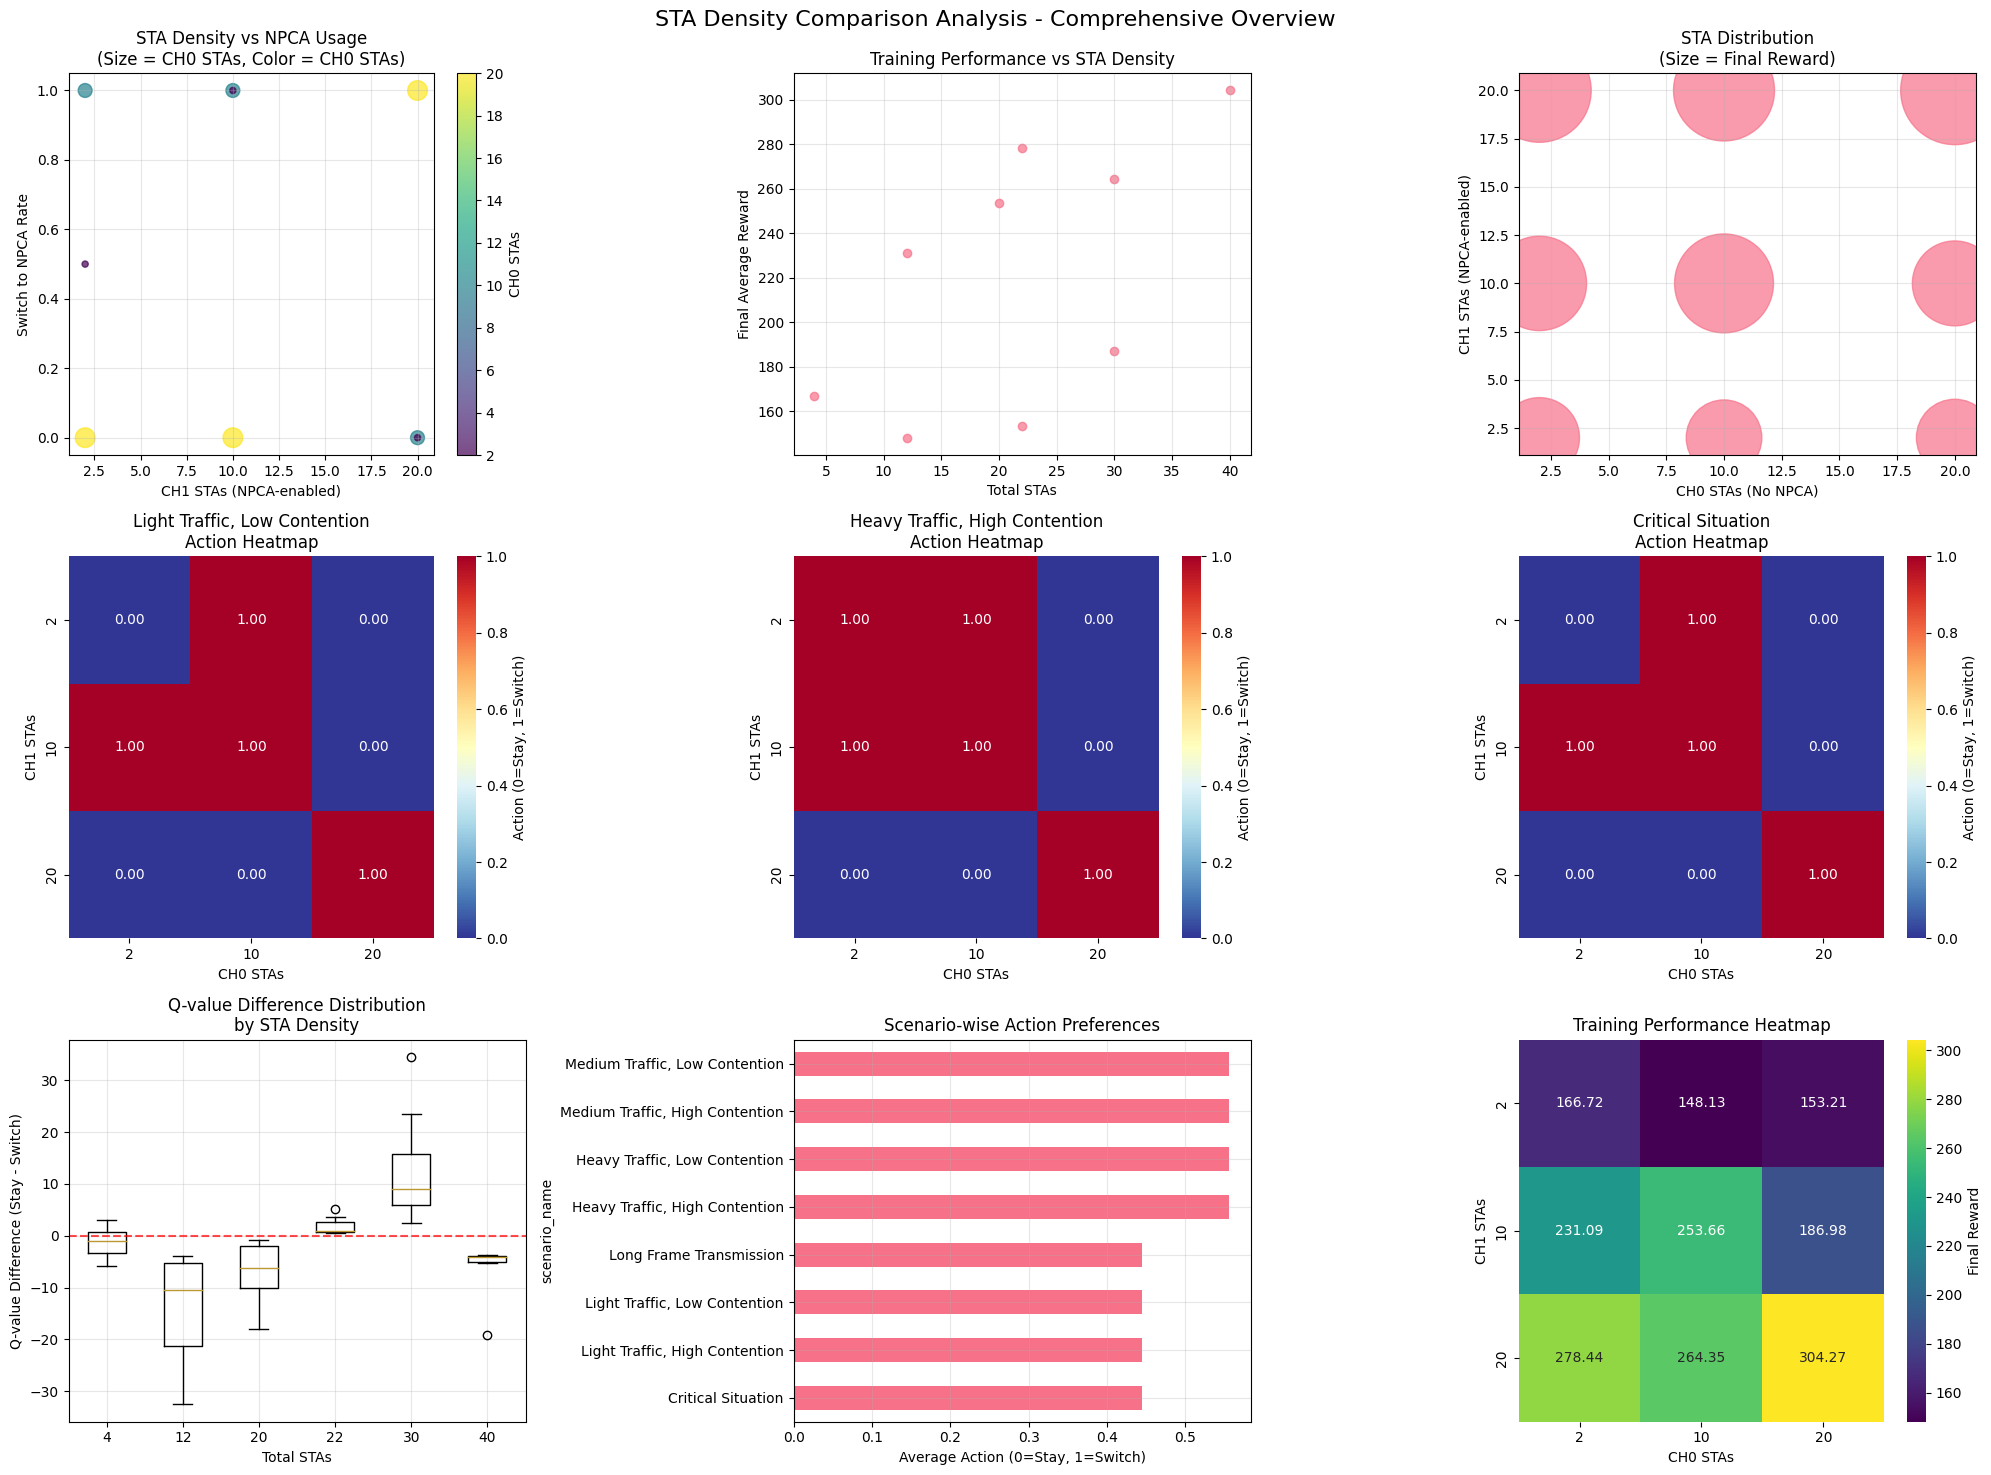

In [ ]:
# 전체 분석 결과 시각화
fig = plt.figure(figsize=(20, 15))

# 1. STA Density vs Switch Rate
ax1 = plt.subplot(3, 3, 1)
scatter = ax1.scatter(action_summary['ch1_stas'], action_summary['Switch_Rate'], 
                     s=action_summary['ch0_stas']*10, alpha=0.7, c=action_summary['ch0_stas'], cmap='viridis')
ax1.set_xlabel('CH1 STAs (NPCA-enabled)')
ax1.set_ylabel('Switch to NPCA Rate')
ax1.set_title('STA Density vs NPCA Usage\n(Size = CH0 STAs, Color = CH0 STAs)')
plt.colorbar(scatter, ax=ax1, label='CH0 STAs')
ax1.grid(True, alpha=0.3)

# 2. Training Performance vs Density
ax2 = plt.subplot(3, 3, 2)
ax2.scatter(model_info_df['total_stas'], model_info_df['final_reward'], alpha=0.7)
ax2.set_xlabel('Total STAs')
ax2.set_ylabel('Final Average Reward')
ax2.set_title('Training Performance vs STA Density')
ax2.grid(True, alpha=0.3)

# 3. CH0 vs CH1 STA Distribution
ax3 = plt.subplot(3, 3, 3)
ax3.scatter(model_info_df['ch0_stas'], model_info_df['ch1_stas'], 
           s=model_info_df['final_reward']*20, alpha=0.7)
ax3.set_xlabel('CH0 STAs (No NPCA)')
ax3.set_ylabel('CH1 STAs (NPCA-enabled)')
ax3.set_title('STA Distribution\n(Size = Final Reward)')
ax3.grid(True, alpha=0.3)

# 4-6. 특정 시나리오들에 대한 히트맵
for i, scenario_name in enumerate(['Light Traffic, Low Contention', 'Heavy Traffic, High Contention', 'Critical Situation']):
    ax = plt.subplot(3, 3, 4+i)
    
    scenario_data = results_df[results_df['scenario_name'] == scenario_name]
    pivot_data = scenario_data.pivot_table(values='predicted_action', 
                                          index='ch1_stas', 
                                          columns='ch0_stas', 
                                          aggfunc='mean')
    
    if not pivot_data.empty:
        sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                   cbar_kws={'label': 'Action (0=Stay, 1=Switch)'}, ax=ax)
        ax.set_title(f'{scenario_name}\nAction Heatmap')
        ax.set_xlabel('CH0 STAs')
        ax.set_ylabel('CH1 STAs')

# 7. Q-value 차이 분석
ax7 = plt.subplot(3, 3, 7)
results_df['q_diff'] = [q[0] - q[1] for q in results_df['q_values']]  # Stay Q - Switch Q
box_data = [group['q_diff'].values for name, group in results_df.groupby('total_stas')]
box_labels = sorted(results_df['total_stas'].unique())
ax7.boxplot(box_data, labels=box_labels)
ax7.set_xlabel('Total STAs')
ax7.set_ylabel('Q-value Difference (Stay - Switch)')
ax7.set_title('Q-value Difference Distribution\nby STA Density')
ax7.grid(True, alpha=0.3)
ax7.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 8. 시나리오별 액션 분포
ax8 = plt.subplot(3, 3, 8)
scenario_counts = results_df.groupby('scenario_name')['predicted_action'].mean().sort_values()
scenario_counts.plot(kind='barh', ax=ax8)
ax8.set_xlabel('Average Action (0=Stay, 1=Switch)')
ax8.set_title('Scenario-wise Action Preferences')
ax8.grid(True, alpha=0.3)

# 9. 학습 성능 히트맵
ax9 = plt.subplot(3, 3, 9)
performance_pivot = model_info_df.pivot_table(values='final_reward', 
                                            index='ch1_stas', 
                                            columns='ch0_stas', 
                                            aggfunc='mean')
if not performance_pivot.empty:
    sns.heatmap(performance_pivot, annot=True, fmt='.2f', cmap='viridis', 
               cbar_kws={'label': 'Final Reward'}, ax=ax9)
    ax9.set_title('Training Performance Heatmap')
    ax9.set_xlabel('CH0 STAs')
    ax9.set_ylabel('CH1 STAs')

plt.suptitle('STA Density Comparison Analysis - Comprehensive Overview', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

🚀 Starting comprehensive baseline comparison...
COMPREHENSIVE COMPARISON - STA DENSITY EXPERIMENTS WITH BASELINES

📊 BASELINE COMPARISON FOR EACH STA CONFIGURATION:
----------------------------------------------------------------------

🔍 Configuration: CH0=2, CH1=2
--------------------------------------------------
Evaluating Primary-Only...
Evaluating NPCA-Only...
  Primary-Only :  60.17
  NPCA-Only    :  63.56
  DRL (Trained): 166.72
  🏆 Best: DRL (166.72)
  📈 DRL vs Primary-Only: +106.55
  📈 DRL vs NPCA-Only: +103.15

🔍 Configuration: CH0=10, CH1=2
--------------------------------------------------
Evaluating Primary-Only...
Evaluating NPCA-Only...
  Primary-Only :  51.47
  NPCA-Only    :  57.21
  DRL (Trained): 148.13
  🏆 Best: DRL (148.13)
  📈 DRL vs Primary-Only: +96.67
  📈 DRL vs NPCA-Only: +90.92

🔍 Configuration: CH0=20, CH1=2
--------------------------------------------------
Evaluating Primary-Only...
Evaluating NPCA-Only...
  Primary-Only :  61.97
  NPCA-Only    :  38.54
 

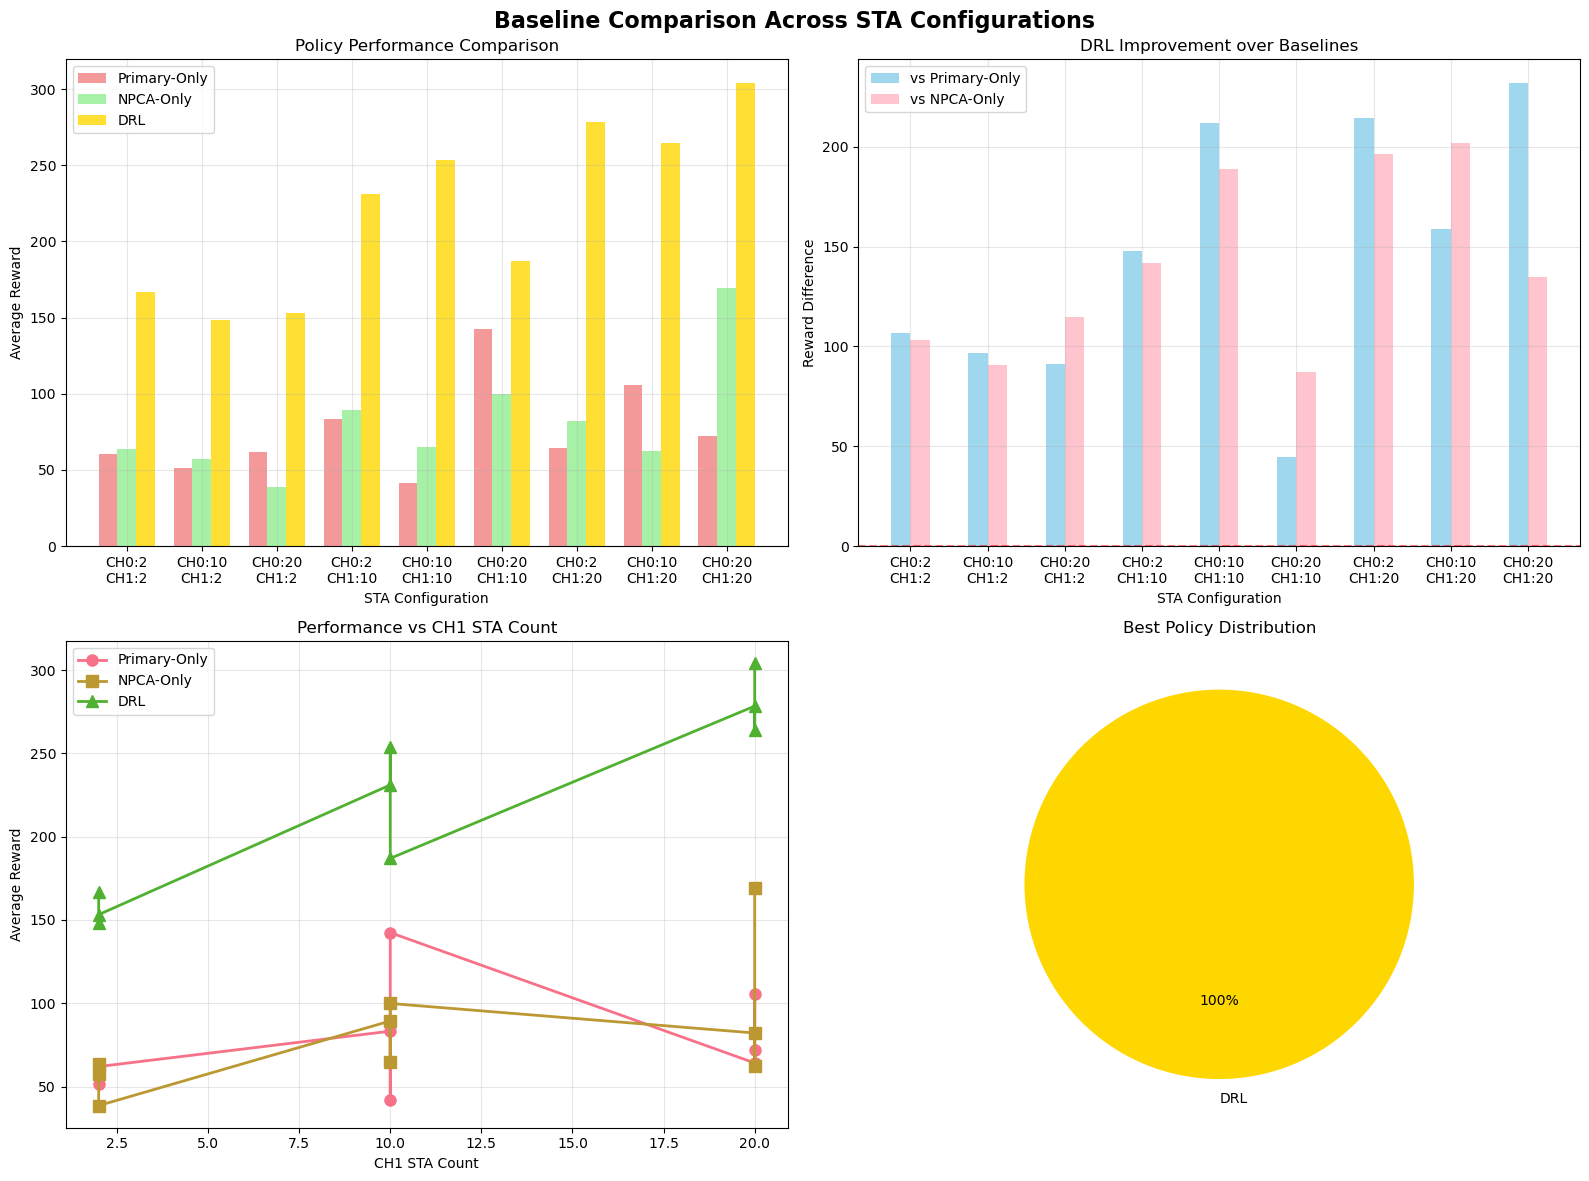


📊 BASELINE COMPARISON SUMMARY:
--------------------------------------------------
DRL wins: 9/9 configurations
Primary-Only wins: 0/9 configurations
NPCA-Only wins: 0/9 configurations

Average DRL improvement:
  vs Primary-Only: +144.87
  vs NPCA-Only: +139.94

Baseline comparison results saved to ./density_comparison_analysis_results/baseline_comparison_results.csv


In [ ]:
def comprehensive_comparison_with_baselines(models_df):
    """모든 모델에 대한 종합 비교 및 baseline 비교 포함"""
    if models_df.empty:
        print("No models to compare")
        return
    
    print("=" * 80)
    print("COMPREHENSIVE COMPARISON - STA DENSITY EXPERIMENTS WITH BASELINES")
    print("=" * 80)
    
    # 수치형 데이터만 필터링
    numeric_models = models_df[models_df['ch1_stas'].apply(lambda x: isinstance(x, (int, float)))].copy()
    
    if numeric_models.empty:
        print("No models with valid STA counts for comprehensive analysis")
        return
    
    # CH1 STA 수별 정렬
    numeric_models = numeric_models.sort_values('ch1_stas')
    
    print(f"\n📊 BASELINE COMPARISON FOR EACH STA CONFIGURATION:")
    print("-" * 70)
    
    # baseline_evaluation 모듈 import
    import sys
    sys.path.append('.')
    from baseline_evaluation import create_baseline_config, evaluate_baseline_policy, FixedPolicy
    
    baseline_comparison_results = []
    
    for _, row in numeric_models.iterrows():
        ch0_stas = int(row['ch0_stas'])
        ch1_stas = int(row['ch1_stas'])
        
        print(f"\n🔍 Configuration: CH0={ch0_stas}, CH1={ch1_stas}")
        print("-" * 50)
        
        # 환경 설정 (해당 STA 수로)
        channels, stas_config = create_baseline_config(
            obss_duration=100, ppdu_variant='medium'
        )
        
        # STA 수 수정
        # CH0 STA 설정
        stas_config = []
        for i in range(ch0_stas):
            stas_config.append({
                "sta_id": i,
                "channel_id": 0,
                "npca_enabled": False,
                "ppdu_duration": 33,
                "radio_transition_time": 1
            })
        
        # CH1 STA 설정
        for i in range(ch1_stas):
            stas_config.append({
                "sta_id": i,
                "channel_id": 1,
                "npca_enabled": True,
                "ppdu_duration": 33,
                "radio_transition_time": 1
            })
        
        # Primary-Only baseline 평가
        try:
            primary_result = evaluate_baseline_policy(
                FixedPolicy.primary_only, "Primary-Only",
                channels, stas_config, num_episodes=30, num_slots_per_episode=1000
            )
            primary_reward = primary_result['avg_reward']
        except Exception as e:
            print(f"Error evaluating Primary-Only: {e}")
            primary_reward = 0.0
        
        # NPCA-Only baseline 평가
        try:
            npca_result = evaluate_baseline_policy(
                FixedPolicy.npca_only, "NPCA-Only",
                channels, stas_config, num_episodes=30, num_slots_per_episode=1000
            )
            npca_reward = npca_result['avg_reward']
        except Exception as e:
            print(f"Error evaluating NPCA-Only: {e}")
            npca_reward = 0.0
        
        # DRL 성능
        drl_reward = row['final_avg_reward']
        
        # 결과 출력
        print(f"  Primary-Only : {primary_reward:6.2f}")
        print(f"  NPCA-Only    : {npca_reward:6.2f}")
        print(f"  DRL (Trained): {drl_reward:6.2f}")
        
        # 최고 성능 찾기
        best_reward = max(primary_reward, npca_reward, drl_reward)
        if drl_reward == best_reward:
            best_policy = "DRL"
            improvement_vs_primary = drl_reward - primary_reward
            improvement_vs_npca = drl_reward - npca_reward
        elif primary_reward == best_reward:
            best_policy = "Primary-Only"
            improvement_vs_primary = 0
            improvement_vs_npca = primary_reward - npca_reward
        else:
            best_policy = "NPCA-Only"
            improvement_vs_primary = npca_reward - primary_reward
            improvement_vs_npca = 0
        
        print(f"  🏆 Best: {best_policy} ({best_reward:.2f})")
        
        if best_policy == "DRL":
            print(f"  📈 DRL vs Primary-Only: +{improvement_vs_primary:.2f}")
            print(f"  📈 DRL vs NPCA-Only: +{improvement_vs_npca:.2f}")
        
        # 결과 저장
        baseline_comparison_results.append({
            'ch0_stas': ch0_stas,
            'ch1_stas': ch1_stas,
            'primary_only': primary_reward,
            'npca_only': npca_reward,
            'drl': drl_reward,
            'best_policy': best_policy,
            'best_reward': best_reward,
            'drl_vs_primary': improvement_vs_primary if best_policy == "DRL" else drl_reward - primary_reward,
            'drl_vs_npca': improvement_vs_npca if best_policy == "DRL" else drl_reward - npca_reward
        })
    
    # 전체 결과 시각화
    if baseline_comparison_results:
        comparison_df = pd.DataFrame(baseline_comparison_results)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Baseline Comparison Across STA Configurations', fontsize=16, fontweight='bold')
        
        # 1. 모든 정책 성능 비교
        ax1 = axes[0, 0]
        x_pos = np.arange(len(comparison_df))
        width = 0.25
        
        ax1.bar(x_pos - width, comparison_df['primary_only'], width, label='Primary-Only', alpha=0.8, color='lightcoral')
        ax1.bar(x_pos, comparison_df['npca_only'], width, label='NPCA-Only', alpha=0.8, color='lightgreen')
        ax1.bar(x_pos + width, comparison_df['drl'], width, label='DRL', alpha=0.8, color='gold')
        
        ax1.set_title('Policy Performance Comparison')
        ax1.set_xlabel('STA Configuration')
        ax1.set_ylabel('Average Reward')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([f"CH0:{row['ch0_stas']}\nCH1:{row['ch1_stas']}" for _, row in comparison_df.iterrows()])
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. DRL 개선 정도
        ax2 = axes[0, 1]
        ax2.bar(x_pos - width/2, comparison_df['drl_vs_primary'], width, label='vs Primary-Only', alpha=0.8, color='skyblue')
        ax2.bar(x_pos + width/2, comparison_df['drl_vs_npca'], width, label='vs NPCA-Only', alpha=0.8, color='lightpink')
        
        ax2.set_title('DRL Improvement over Baselines')
        ax2.set_xlabel('STA Configuration')
        ax2.set_ylabel('Reward Difference')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([f"CH0:{row['ch0_stas']}\nCH1:{row['ch1_stas']}" for _, row in comparison_df.iterrows()])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        # 3. CH1 STA 수 vs 성능 관계
        ax3 = axes[1, 0]
        ax3.plot(comparison_df['ch1_stas'], comparison_df['primary_only'], 'o-', label='Primary-Only', linewidth=2, markersize=8)
        ax3.plot(comparison_df['ch1_stas'], comparison_df['npca_only'], 's-', label='NPCA-Only', linewidth=2, markersize=8)
        ax3.plot(comparison_df['ch1_stas'], comparison_df['drl'], '^-', label='DRL', linewidth=2, markersize=8)
        
        ax3.set_title('Performance vs CH1 STA Count')
        ax3.set_xlabel('CH1 STA Count')
        ax3.set_ylabel('Average Reward')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. 최고 성능 정책 분포
        ax4 = axes[1, 1]
        policy_counts = comparison_df['best_policy'].value_counts()
        colors = ['gold', 'lightcoral', 'lightgreen']
        ax4.pie(policy_counts.values, labels=policy_counts.index, colors=colors[:len(policy_counts)], 
                autopct='%1.0f%%', startangle=90)
        ax4.set_title('Best Policy Distribution')
        
        plt.tight_layout()
        plt.savefig(f"{results_dir}/baseline_comparison_analysis.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # 요약 통계
        print(f"\n📊 BASELINE COMPARISON SUMMARY:")
        print("-" * 50)
        
        drl_wins = sum(1 for result in baseline_comparison_results if result['best_policy'] == 'DRL')
        primary_wins = sum(1 for result in baseline_comparison_results if result['best_policy'] == 'Primary-Only')
        npca_wins = sum(1 for result in baseline_comparison_results if result['best_policy'] == 'NPCA-Only')
        
        print(f"DRL wins: {drl_wins}/{len(baseline_comparison_results)} configurations")
        print(f"Primary-Only wins: {primary_wins}/{len(baseline_comparison_results)} configurations")
        print(f"NPCA-Only wins: {npca_wins}/{len(baseline_comparison_results)} configurations")
        
        avg_drl_improvement_primary = np.mean([r['drl_vs_primary'] for r in baseline_comparison_results])
        avg_drl_improvement_npca = np.mean([r['drl_vs_npca'] for r in baseline_comparison_results])
        
        print(f"\nAverage DRL improvement:")
        print(f"  vs Primary-Only: {avg_drl_improvement_primary:+.2f}")
        print(f"  vs NPCA-Only: {avg_drl_improvement_npca:+.2f}")
        
        # 결과를 CSV로 저장
        comparison_df.to_csv(f"{results_dir}/baseline_comparison_results.csv", index=False)
        print(f"\nBaseline comparison results saved to {results_dir}/baseline_comparison_results.csv")
    
    print("=" * 80)
    
    return baseline_comparison_results

# 실행
print("🚀 Starting comprehensive baseline comparison...")
baseline_results = comprehensive_comparison_with_baselines(models_df)

## Step 9: 특정 입력값에 대한 모든 모델 비교

In [ ]:
# 사용자 정의 입력으로 모든 모델 비교
custom_input = [80, 1, 33, 2]  # [obss_remain, radio_time, ppdu_duration, cw_index]

print(f"🎯 입력값 {custom_input}에 대한 모든 모델 예측 비교:\n")
print(f"{'Model Name':<25} {'CH0':<4} {'CH1':<4} {'Action':<6} {'Q_Stay':<8} {'Q_Switch':<8} {'Confidence':<10}")
print("-" * 80)

comparison_results = []

for model_data in density_models:
    try:
        model, _ = load_model(model_data['path'])
        result = predict_q_values(model, custom_input)
        
        action_str = "Stay" if result['predicted_action'] == 0 else "Switch"
        conf_str = f"{result['confidence'][result['predicted_action']]:.3f}"
        
        print(f"{model_data['name']:<25} {model_data['ch0_stas']:<4} {model_data['ch1_stas']:<4} "
              f"{action_str:<6} {result['q_values'][0]:<8.3f} {result['q_values'][1]:<8.3f} {conf_str:<10}")
        
        comparison_results.append({
            'model_name': model_data['name'],
            'ch0_stas': model_data['ch0_stas'],
            'ch1_stas': model_data['ch1_stas'],
            'total_stas': model_data['total_stas'],
            'action': result['predicted_action'],
            'q_stay': result['q_values'][0],
            'q_switch': result['q_values'][1],
            'confidence': result['confidence'][result['predicted_action']]
        })
        
    except Exception as e:
        print(f"{model_data['name']:<25} ERROR: {str(e)[:30]}")

print("\n" + "="*80)

# 결과 분석
if comparison_results:
    comp_df = pd.DataFrame(comparison_results)
    
    stay_models = comp_df[comp_df['action'] == 0]
    switch_models = comp_df[comp_df['action'] == 1]
    
    print(f"\n📊 액션 분포:")
    print(f"Stay Primary: {len(stay_models)} 모델 ({len(stay_models)/len(comp_df)*100:.1f}%)")
    print(f"Switch NPCA: {len(switch_models)} 모델 ({len(switch_models)/len(comp_df)*100:.1f}%)")
    
    if len(stay_models) > 0:
        print(f"\nStay 선택 모델들의 평균 STA 밀도: CH0={stay_models['ch0_stas'].mean():.1f}, CH1={stay_models['ch1_stas'].mean():.1f}")
    
    if len(switch_models) > 0:
        print(f"Switch 선택 모델들의 평균 STA 밀도: CH0={switch_models['ch0_stas'].mean():.1f}, CH1={switch_models['ch1_stas'].mean():.1f}")


🎯 입력값 [80, 1, 33, 2]에 대한 모든 모델 예측 비교:

Model Name                CH0  CH1  Action Q_Stay   Q_Switch Confidence
--------------------------------------------------------------------------------
ch0_2_ch1_2               2    2    Switch 0.797    4.190    0.967     
ch0_10_ch1_2              10   2    Switch -6.097   11.940   1.000     
ch0_2_ch1_10              2    10   Switch -5.195   6.278    1.000     
ch0_10_ch1_10             10   10   Switch -1.793   7.326    1.000     
ch0_20_ch1_2              20   2    Stay   4.833    3.485    0.794     
ch0_2_ch1_20              2    20   Stay   3.131    1.484    0.839     
ch0_20_ch1_10             20   10   Stay   3.346    -7.960   1.000     
ch0_10_ch1_20             10   20   Stay   4.457    -6.336   1.000     
ch0_20_ch1_20             20   20   Switch 0.036    4.607    0.990     


📊 액션 분포:
Stay Primary: 4 모델 (44.4%)
Switch NPCA: 5 모델 (55.6%)

Stay 선택 모델들의 평균 STA 밀도: CH0=13.0, CH1=13.0
Switch 선택 모델들의 평균 STA 밀도: CH0=8.8, CH1=8.8


## Step 10: 대화형 비교 도구

In [ ]:
# 사용자가 자유롭게 수정할 수 있는 대화형 섹션

# 여기서 원하는 입력값들을 정의하세요
interactive_inputs = [
    [30, 1, 33, 1],   # 테스트 1
    [100, 1, 165, 3], # 테스트 2 - 큰 프레임
    [200, 1, 33, 0],  # 테스트 3 - 매우 긴 OBSS
]

print("🎮 대화형 비교 도구")
print("위의 interactive_inputs 리스트를 수정하여 원하는 입력값들을 테스트해보세요!\n")

for test_idx, test_input in enumerate(interactive_inputs):
    print(f"\n{'='*60}")
    print(f"테스트 {test_idx + 1}: {test_input}")
    print(f"[OBSS={test_input[0]}, Radio={test_input[1]}, PPDU={test_input[2]}, CW={test_input[3]}]")
    print(f"{'='*60}")
    
    # 모든 모델에 대해 예측
    test_results = []
    
    for model_data in density_models:
        try:
            model, _ = load_model(model_data['path'])
            result = predict_q_values(model, test_input)
            
            test_results.append({
                'name': model_data['name'],
                'ch0': model_data['ch0_stas'],
                'ch1': model_data['ch1_stas'],
                'action': result['predicted_action'],
                'action_name': result['action_name'],
                'q_stay': result['q_values'][0],
                'q_switch': result['q_values'][1],
                'q_diff': result['q_values'][0] - result['q_values'][1]
            })
            
        except Exception as e:
            print(f"Error loading {model_data['name']}: {str(e)}")
    
    if test_results:
        # 결과를 Q-value 차이로 정렬
        test_results.sort(key=lambda x: x['q_diff'], reverse=True)
        
        print(f"\n{'Model':<25} {'CH0':<4} {'CH1':<4} {'Decision':<12} {'Q_Stay':<8} {'Q_Switch':<8} {'Q_Diff':<8}")
        print("-" * 75)
        
        for result in test_results:
            print(f"{result['name']:<25} {result['ch0']:<4} {result['ch1']:<4} "
                  f"{result['action_name']:<12} {result['q_stay']:<8.3f} {result['q_switch']:<8.3f} {result['q_diff']:<8.3f}")
        
        # 간단한 통계
        stay_count = sum(1 for r in test_results if r['action'] == 0)
        switch_count = len(test_results) - stay_count
        
        print(f"\n📊 결과 요약: Stay={stay_count}, Switch={switch_count}")
        
        if switch_count > 0:
            switch_models = [r for r in test_results if r['action'] == 1]
            avg_ch0_switch = sum(r['ch0'] for r in switch_models) / len(switch_models)
            avg_ch1_switch = sum(r['ch1'] for r in switch_models) / len(switch_models)
            print(f"Switch 선택 모델들의 평균 밀도: CH0={avg_ch0_switch:.1f}, CH1={avg_ch1_switch:.1f}")
            
print("\n🎉 대화형 비교 완료!")
print("\n💡 Tip: interactive_inputs를 수정하여 다른 네트워크 상황들을 테스트해보세요!")
print("   - [obss_remain, radio_time, ppdu_duration, cw_index]")
print("   - obss_remain: 0-200 (OBSS 잔여 시간)")
print("   - radio_time: 1 (고정)")
print("   - ppdu_duration: 20/33/50/165 (프레임 크기)")
print("   - cw_index: 0-7 (충돌 정도, 0=낮음, 7=높음)")

## 📋 결론 및 인사이트

이 분석을 통해 다음을 확인할 수 있습니다:

### 🎯 주요 발견사항:
1. **STA 밀도 효과**: 각 채널의 STA 개수가 NPCA 사용 패턴에 미치는 영향
2. **학습 성능**: 네트워크 밀도에 따른 DRL 모델의 학습 성능 차이
3. **의사결정 패턴**: 동일한 입력에 대해 서로 다른 밀도 환경에서 훈련된 모델들의 서로 다른 반응

### 🔍 사용 방법:
- **Step 9**: 특정 네트워크 상황에서 모든 모델들의 반응 비교
- **Step 10**: 대화형 도구로 다양한 시나리오 테스트
- **Step 8**: 종합 시각화로 전체 패턴 파악

### 🚀 확장 가능성:
- 추가 모델들이 학습되면 자동으로 분석에 포함
- 새로운 테스트 시나리오 추가 가능
- 더 정교한 성능 메트릭 도입 가능

## Step 11: Training Learning Curves Analysis

각 STA density 모델들의 학습 곡선을 비교하여 학습 과정에서의 차이점을 분석합니다.

🚀 Starting Learning Curves Analysis...
📈 Learning Curves Analysis
✅ ch0_2_ch1_2: 1000 episodes, Final: 166.72
✅ ch0_10_ch1_2: 1000 episodes, Final: 148.13
✅ ch0_2_ch1_10: 1000 episodes, Final: 231.09
✅ ch0_10_ch1_10: 1000 episodes, Final: 253.66
✅ ch0_20_ch1_2: 1000 episodes, Final: 153.21
✅ ch0_2_ch1_20: 1000 episodes, Final: 278.44
✅ ch0_20_ch1_10: 1000 episodes, Final: 186.98
✅ ch0_10_ch1_20: 1000 episodes, Final: 264.35
✅ ch0_20_ch1_20: 1000 episodes, Final: 304.27

📊 Successfully loaded 9 learning curves

🎯 Convergence Analysis
--------------------------------------------------
ch0_2_ch1_2         : Converged at episode 19
ch0_10_ch1_2        : Converged at episode 19
ch0_2_ch1_10        : Converged at episode 19
ch0_10_ch1_10       : Converged at episode 19
ch0_20_ch1_2        : Converged at episode 19
ch0_2_ch1_20        : Converged at episode 19
ch0_20_ch1_10       : Converged at episode 19
ch0_10_ch1_20       : Converged at episode 19
ch0_20_ch1_20       : Converged at episode

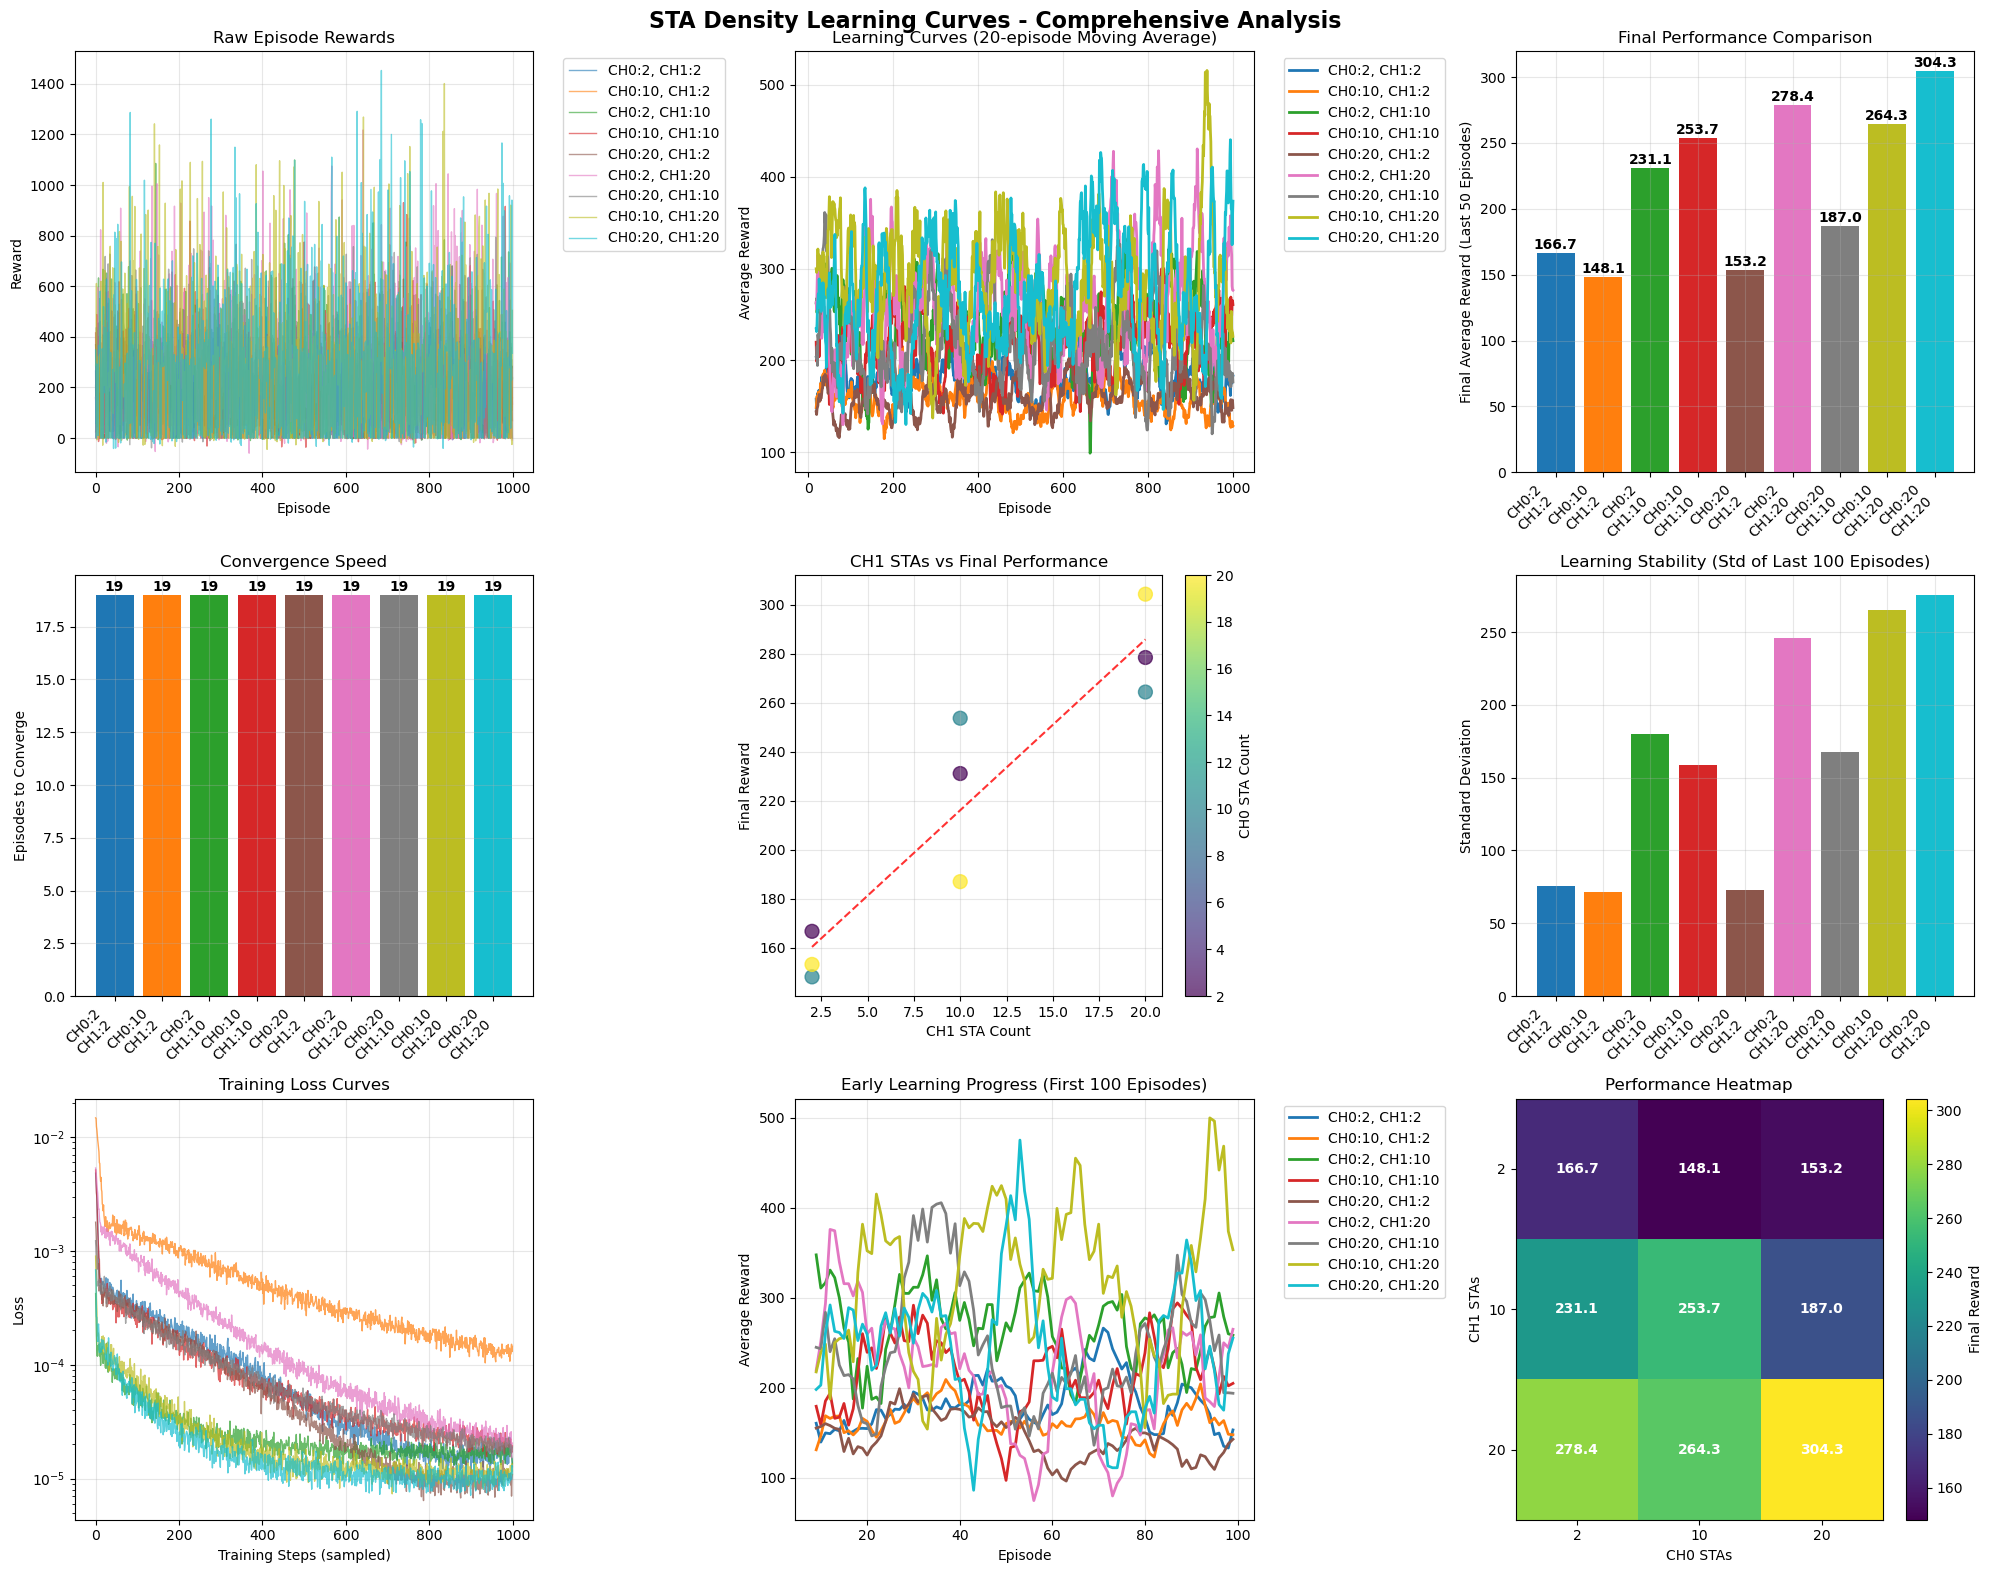


📊 LEARNING CURVES SUMMARY:
------------------------------------------------------------
🏆 Best Final Performance: ch0_20_ch1_20 (304.27)
🏃 Fastest Convergence: ch0_2_ch1_2 (19 episodes)
📈 Most Stable Learning: ch0_10_ch1_2

🔍 CH1 STA Count vs Final Reward Correlation: 0.932
   → Strong positive correlation: More CH1 STAs significantly improve performance

✅ Learning curves analysis complete!
📁 Results saved to ./density_comparison_analysis_results/learning_curves_analysis.png


In [19]:
def analyze_learning_curves(density_models):
    """모든 density 모델들의 학습 곡선 분석 및 시각화"""
    
    print("📈 Learning Curves Analysis")
    print("=" * 60)
    
    learning_data = []
    
    # 각 모델에서 learning curve 데이터 추출
    for model_data in density_models:
        try:
            model_path = model_data['path']
            checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
            
            # Episode rewards와 losses 추출
            episode_rewards = checkpoint.get('episode_rewards', [])
            episode_losses = checkpoint.get('episode_losses', [])
            
            if episode_rewards:
                learning_data.append({
                    'name': model_data['name'],
                    'ch0_stas': model_data['ch0_stas'],
                    'ch1_stas': model_data['ch1_stas'],
                    'total_stas': model_data['total_stas'],
                    'episode_rewards': episode_rewards,
                    'episode_losses': episode_losses,
                    'total_episodes': len(episode_rewards),
                    'final_reward': np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards),
                    'max_reward': np.max(episode_rewards),
                    'convergence_episode': None  # Will be calculated
                })
                
                print(f"✅ {model_data['name']}: {len(episode_rewards)} episodes, Final: {learning_data[-1]['final_reward']:.2f}")
            else:
                print(f"❌ {model_data['name']}: No episode rewards found")
                
        except Exception as e:
            print(f"❌ {model_data['name']}: Error loading - {str(e)}")
    
    if not learning_data:
        print("No valid learning data found!")
        return
    
    print(f"\n📊 Successfully loaded {len(learning_data)} learning curves")
    
    return learning_data

def calculate_convergence_metrics(learning_data):
    """수렴 메트릭 계산"""
    
    print("\n🎯 Convergence Analysis")
    print("-" * 50)
    
    convergence_threshold = 10.0  # 수렴 임계값 (reward)
    
    for data in learning_data:
        rewards = data['episode_rewards']
        
        # Moving average 계산 (window size = 20)
        if len(rewards) >= 20:
            moving_avg = np.convolve(rewards, np.ones(20)/20, mode='valid')
            
            # 수렴 지점 찾기 (moving average가 threshold를 넘는 첫 번째 지점)
            convergence_idx = next((i for i, r in enumerate(moving_avg) if r >= convergence_threshold), None)
            
            if convergence_idx is not None:
                data['convergence_episode'] = convergence_idx + 19  # moving average offset 보정
                print(f"{data['name']:<20}: Converged at episode {data['convergence_episode']}")
            else:
                data['convergence_episode'] = len(rewards)
                print(f"{data['name']:<20}: Did not converge (threshold: {convergence_threshold})")
        else:
            data['convergence_episode'] = len(rewards)
            print(f"{data['name']:<20}: Not enough episodes for convergence analysis")

def plot_learning_curves(learning_data):
    """학습 곡선 시각화"""
    
    # Color map for different configurations
    colors = plt.cm.tab10(np.linspace(0, 1, len(learning_data)))
    
    fig = plt.figure(figsize=(20, 16))
    
    # 1. 모든 학습 곡선 (Raw)
    ax1 = plt.subplot(3, 3, 1)
    for i, data in enumerate(learning_data):
        rewards = data['episode_rewards']
        ax1.plot(rewards, alpha=0.6, color=colors[i], linewidth=1,
                label=f"CH0:{data['ch0_stas']}, CH1:{data['ch1_stas']}")
    
    ax1.set_title('Raw Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. 이동 평균 (Moving Average)
    ax2 = plt.subplot(3, 3, 2)
    for i, data in enumerate(learning_data):
        rewards = data['episode_rewards']
        if len(rewards) >= 20:
            moving_avg = np.convolve(rewards, np.ones(20)/20, mode='valid')
            ax2.plot(range(19, len(rewards)), moving_avg, color=colors[i], linewidth=2,
                    label=f"CH0:{data['ch0_stas']}, CH1:{data['ch1_stas']}")
    
    ax2.set_title('Learning Curves (20-episode Moving Average)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Reward')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. 최종 성능 비교
    ax3 = plt.subplot(3, 3, 3)
    names = [f"CH0:{d['ch0_stas']}\nCH1:{d['ch1_stas']}" for d in learning_data]
    final_rewards = [d['final_reward'] for d in learning_data]
    
    bars = ax3.bar(range(len(names)), final_rewards, color=colors[:len(learning_data)])
    ax3.set_title('Final Performance Comparison')
    ax3.set_ylabel('Final Average Reward (Last 50 Episodes)')
    ax3.set_xticks(range(len(names)))
    ax3.set_xticklabels(names, rotation=45, ha='right')
    
    # 막대 위에 값 표시
    for bar, reward in zip(bars, final_rewards):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(final_rewards)*0.01,
                f'{reward:.1f}', ha='center', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. 수렴 속도 비교
    ax4 = plt.subplot(3, 3, 4)
    convergence_episodes = [d['convergence_episode'] for d in learning_data]
    
    bars = ax4.bar(range(len(names)), convergence_episodes, color=colors[:len(learning_data)])
    ax4.set_title('Convergence Speed')
    ax4.set_ylabel('Episodes to Converge')
    ax4.set_xticks(range(len(names)))
    ax4.set_xticklabels(names, rotation=45, ha='right')
    
    # 막대 위에 값 표시
    for bar, episodes in zip(bars, convergence_episodes):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(convergence_episodes)*0.01,
                f'{episodes}', ha='center', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. CH1 STA 수 vs 최종 성능
    ax5 = plt.subplot(3, 3, 5)
    ch1_counts = [d['ch1_stas'] for d in learning_data]
    ax5.scatter(ch1_counts, final_rewards, s=100, c=[d['ch0_stas'] for d in learning_data], 
                cmap='viridis', alpha=0.7)
    
    # Trend line
    z = np.polyfit(ch1_counts, final_rewards, 1)
    p = np.poly1d(z)
    ax5.plot(sorted(ch1_counts), p(sorted(ch1_counts)), "r--", alpha=0.8)
    
    ax5.set_title('CH1 STAs vs Final Performance')
    ax5.set_xlabel('CH1 STA Count')
    ax5.set_ylabel('Final Reward')
    ax5.grid(True, alpha=0.3)
    
    # Colorbar for CH0 STAs
    cbar = plt.colorbar(ax5.collections[0], ax=ax5)
    cbar.set_label('CH0 STA Count')
    
    # 6. 학습 안정성 (표준편차)
    ax6 = plt.subplot(3, 3, 6)
    stabilities = []
    for data in learning_data:
        rewards = data['episode_rewards']
        if len(rewards) >= 100:
            stability = np.std(rewards[-100:])  # 마지막 100 에피소드의 표준편차
        else:
            stability = np.std(rewards)
        stabilities.append(stability)
    
    bars = ax6.bar(range(len(names)), stabilities, color=colors[:len(learning_data)])
    ax6.set_title('Learning Stability (Std of Last 100 Episodes)')
    ax6.set_ylabel('Standard Deviation')
    ax6.set_xticks(range(len(names)))
    ax6.set_xticklabels(names, rotation=45, ha='right')
    ax6.grid(True, alpha=0.3)
    
    # 7. Loss curves (if available)
    ax7 = plt.subplot(3, 3, 7)
    has_loss = False
    for i, data in enumerate(learning_data):
        losses = data['episode_losses']
        if losses:
            # Loss는 step 단위이므로 적당히 샘플링
            if len(losses) > 1000:
                sample_indices = np.linspace(0, len(losses)-1, 1000, dtype=int)
                sampled_losses = [losses[i] for i in sample_indices]
            else:
                sampled_losses = losses
            
            ax7.plot(sampled_losses, alpha=0.7, color=colors[i], linewidth=1)
            has_loss = True
    
    if has_loss:
        ax7.set_title('Training Loss Curves')
        ax7.set_xlabel('Training Steps (sampled)')
        ax7.set_ylabel('Loss')
        ax7.set_yscale('log')
        ax7.grid(True, alpha=0.3)
    else:
        ax7.text(0.5, 0.5, 'No Loss Data Available', ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Training Loss Curves')
    
    # 8. 초기 학습 진행 (첫 100 에피소드)
    ax8 = plt.subplot(3, 3, 8)
    for i, data in enumerate(learning_data):
        rewards = data['episode_rewards'][:100]  # 첫 100 에피소드만
        if len(rewards) >= 20:
            moving_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')  # 10-episode window
            ax8.plot(range(9, len(rewards)), moving_avg, color=colors[i], linewidth=2,
                    label=f"CH0:{data['ch0_stas']}, CH1:{data['ch1_stas']}")
    
    ax8.set_title('Early Learning Progress (First 100 Episodes)')
    ax8.set_xlabel('Episode')
    ax8.set_ylabel('Average Reward')
    ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax8.grid(True, alpha=0.3)
    
    # 9. 성능 히트맵 (CH0 vs CH1)
    ax9 = plt.subplot(3, 3, 9)
    
    # Create pivot table for heatmap
    ch0_values = sorted(list(set(d['ch0_stas'] for d in learning_data)))
    ch1_values = sorted(list(set(d['ch1_stas'] for d in learning_data)))
    
    heatmap_data = np.zeros((len(ch1_values), len(ch0_values)))
    
    for data in learning_data:
        ch0_idx = ch0_values.index(data['ch0_stas'])
        ch1_idx = ch1_values.index(data['ch1_stas'])
        heatmap_data[ch1_idx, ch0_idx] = data['final_reward']
    
    im = ax9.imshow(heatmap_data, cmap='viridis', aspect='auto')
    ax9.set_title('Performance Heatmap')
    ax9.set_xlabel('CH0 STAs')
    ax9.set_ylabel('CH1 STAs')
    ax9.set_xticks(range(len(ch0_values)))
    ax9.set_xticklabels(ch0_values)
    ax9.set_yticks(range(len(ch1_values)))
    ax9.set_yticklabels(ch1_values)
    
    # Add text annotations
    for i in range(len(ch1_values)):
        for j in range(len(ch0_values)):
            if heatmap_data[i, j] > 0:
                ax9.text(j, i, f'{heatmap_data[i, j]:.1f}', ha='center', va='center', color='white', fontweight='bold')
    
    plt.colorbar(im, ax=ax9, label='Final Reward')
    
    plt.suptitle('STA Density Learning Curves - Comprehensive Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{results_dir}/learning_curves_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# 실행
print("🚀 Starting Learning Curves Analysis...")
learning_data = analyze_learning_curves(density_models)

if learning_data:
    calculate_convergence_metrics(learning_data)
    plot_learning_curves(learning_data)
    
    # 요약 통계
    print(f"\n📊 LEARNING CURVES SUMMARY:")
    print("-" * 60)
    
    best_final = max(learning_data, key=lambda x: x['final_reward'])
    fastest_converge = min(learning_data, key=lambda x: x['convergence_episode'])
    most_stable = min(learning_data, key=lambda x: np.std(x['episode_rewards'][-100:]) if len(x['episode_rewards']) >= 100 else float('inf'))
    
    print(f"🏆 Best Final Performance: {best_final['name']} ({best_final['final_reward']:.2f})")
    print(f"🏃 Fastest Convergence: {fastest_converge['name']} ({fastest_converge['convergence_episode']} episodes)")
    print(f"📈 Most Stable Learning: {most_stable['name']}")
    
    # Correlation analysis
    ch1_counts = [d['ch1_stas'] for d in learning_data]
    final_rewards = [d['final_reward'] for d in learning_data]
    correlation = np.corrcoef(ch1_counts, final_rewards)[0, 1]
    
    print(f"\n🔍 CH1 STA Count vs Final Reward Correlation: {correlation:.3f}")
    if correlation > 0.7:
        print("   → Strong positive correlation: More CH1 STAs significantly improve performance")
    elif correlation > 0.3:
        print("   → Moderate positive correlation: CH1 STAs tend to improve performance")
    elif correlation > -0.3:
        print("   → Weak correlation: CH1 STA count has limited effect")
    else:
        print("   → Negative correlation: More CH1 STAs may harm performance")
    
    print(f"\n✅ Learning curves analysis complete!")
    print(f"📁 Results saved to {results_dir}/learning_curves_analysis.png")

else:
    print("❌ No learning data available for analysis")